# 1. Import JSON meeting data

In [35]:
import json
import re

# Helper function to clean text
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace and line breaks
    return text

# Function to clean a meeting entry
def clean_meeting(meeting):
    if isinstance(meeting, dict):
        return {key: clean_text(value) for key, value in meeting.items()}
    elif isinstance(meeting, str):
        return clean_text(meeting)
    else:
        return meeting

# Function to clean the entire dataset
def clean_data(data, term):
    for entry in data:
        entry["name"] = clean_text(entry.get("name", ""))
        entry["group"] = clean_text(entry.get("group", ""))
        entry["origin_country"] = clean_text(entry.get("origin_country", ""))
        entry["national_party"] = clean_text(entry.get("national_party", ""))
        entry["assistants"] = entry.get("assistants", {})

        # Clean meetings if it exists and is a dictionary
        meetings = entry.get("meetings", {})
        if isinstance(meetings, dict):
            for meeting_id, meeting in meetings.items():
                meetings[meeting_id] = clean_meeting(meeting)
        elif isinstance(meetings, str):
            # If meetings is a string like "No meetings for this MEP", just clean it
            entry["meetings"] = clean_text(meetings)

        # Add the term information
        entry["term"] = term

    return data

# File paths
path_9th_term = r"C:\Users\Emilia\Documents\Uni Helsinki\Year Three\AMO Freelance\transparency register\9 term\raw data\9term_meetings_ALL_INFO.json"
path_10th_term = r"C:\Users\Emilia\Documents\Uni Helsinki\Year Three\AMO Freelance\transparency register\10 term\raw data\national party 10-11-2024\mep_meetings_FULL_w_nationalParty.json"

# Load and clean the 9th term data
with open(path_9th_term, 'r', encoding='utf-8') as file:
    data_9th_term = json.load(file)
    cleaned_9th_term = clean_data(data_9th_term, term=9)

# Load and clean the 10th term data
with open(path_10th_term, 'r', encoding='utf-8') as file:
    data_10th_term = json.load(file)
    cleaned_10th_term = clean_data(data_10th_term, term=10)

# Save the cleaned data to new JSON files
with open('cleaned_9th_term.json', 'w', encoding='utf-8') as file:
    json.dump(cleaned_9th_term, file, indent=4, ensure_ascii=False)

with open('cleaned_10th_term.json', 'w', encoding='utf-8') as file:
    json.dump(cleaned_10th_term, file, indent=4, ensure_ascii=False)

print("Data cleaned successfully and saved to 'cleaned_9th_term.json' and 'cleaned_10th_term.json'.")

Data cleaned successfully and saved to 'cleaned_9th_term.json' and 'cleaned_10th_term.json'.


# 2. Find apas via keyword search

In [36]:
import json
import re

# Keywords to search for
keywords = ["apa", "assistant", "accredited assistant", "apas", "parliamentary assistant"]

# Function to check if any keyword exists in the meeting data (reason, meeting_with, or capacity)
def contains_keywords(meeting_info):
    # If the meeting_info is the string "no meetings attended by mep", skip it
    if isinstance(meeting_info, str) and "no meetings attended by mep" in meeting_info.lower():
        return []  # No keywords to match in this case

    # Check if meeting_info is a dictionary or string
    if isinstance(meeting_info, dict):
        # Check in 'reason', 'meeting_with', and 'capacity'
        meeting_text = f"{meeting_info.get('reason', '')} {meeting_info.get('meeting_with', '')} {meeting_info.get('capacity', '')}"
    elif isinstance(meeting_info, str):
        # If it's a string, use it directly
        meeting_text = meeting_info
    else:
        # If it's neither, return no match
        return []

    # Find all matching keywords using word boundaries
    matches = []
    for keyword in keywords:
        # Create a word boundary search pattern for the keyword
        pattern = r'\b' + re.escape(keyword) + r'\b'
        if re.search(pattern, meeting_text, re.IGNORECASE):  # re.IGNORECASE for case-insensitive search
            matches.append(keyword)
    
    return matches

# Function to filter meetings based on the keywords
def filter_meetings(dataset, term_name):
    filtered_meetings = []

    for person in dataset:
        for meeting_id, meeting_info in person['meetings'].items():
            # Get matching keywords
            matched_keywords = contains_keywords(meeting_info)
            
            if matched_keywords:
                # Print the matches found in this meeting
                print(f"Match found for {person['name']} in meeting {meeting_id}:")
                print(f"  Matched Keywords: {', '.join(matched_keywords)}")
                print(f"  Meeting Info: {meeting_info}")
                
                filtered_meetings.append({
                    'name': person['name'],
                    'group': person['group'],
                    'origin_country': person['origin_country'],
                    'national_party': person['national_party'],
                    'meeting_id': meeting_id,
                    'meeting_info': meeting_info,
                    'matched_keywords': matched_keywords  # Save the matched keywords
                })
    
    # Save filtered meetings to a JSON file
    output_filename = f'filtered_meetings_{term_name}.json'
    with open(output_filename, 'w', encoding='utf-8') as f:
        json.dump(filtered_meetings, f, ensure_ascii=False, indent=4)

    print(f"Filtered meetings for {term_name} saved to {output_filename}")

In [37]:
# Process the 10th term
filter_meetings(cleaned_10th_term, "10th_term")

# Process the 9th term
filter_meetings(cleaned_9th_term, "9th_term")

Match found for Udo BULLMANN in meeting 0:
  Matched Keywords: apa
  Meeting Info: {'reason': 'APA meeting with representatives of civil society organizations', 'date': '24-10-2024', 'place': 'Brussels', 'capacity': 'Member', 'meeting_with': 'European Trade Justice Coalition'}
Match found for Udo BULLMANN in meeting 2:
  Matched Keywords: apa
  Meeting Info: {'reason': 'APA meeting with Civil Society Organisations from Argentina', 'date': '16-10-2024', 'place': 'Brussels', 'capacity': 'Member', 'meeting_with': 'Heinrich-Böll-Stiftung FARN CELS Via Libre'}
Match found for Udo BULLMANN in meeting 4:
  Matched Keywords: apa
  Meeting Info: {'reason': 'Exchange of views on situation of Bahá’i, especially women (APA meeting)', 'date': '10-10-2024', 'place': 'Brussels', 'capacity': 'Member', 'meeting_with': "Bahá'í International Community"}
Match found for Udo BULLMANN in meeting 8:
  Matched Keywords: apa
  Meeting Info: {'reason': 'APA attendance on Situation in Gaza and the Middle East', 

# 3. Visualize

In [40]:
apa_meetings_9th_path = "C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/transparency register/apa_meetings_9th_term.json"
apa_meetings_10th_path= "C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/transparency register/apa_meetings_10th_term.json"

with open(apa_meetings_9th_path, 'r', encoding='utf-8') as file:
    apa_meetings_9th = json.load(file)

with open(apa_meetings_10th_path, 'r', encoding='utf-8') as file:
    apa_meetings_10th = json.load(file)

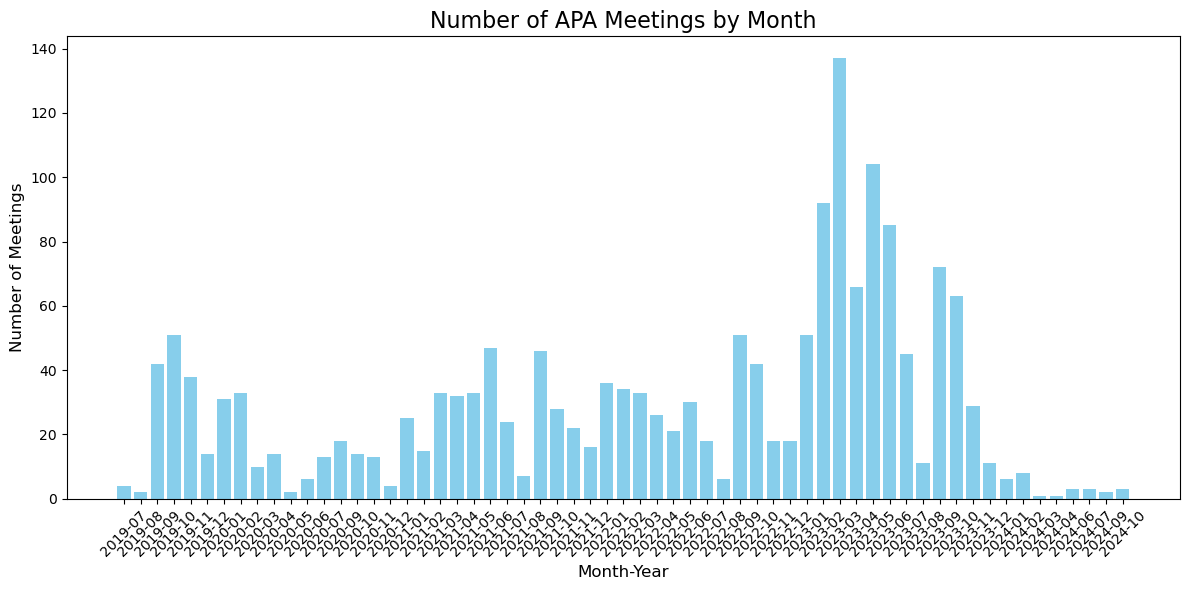

In [53]:
import pandas as pd 
import matplotlib.pyplot as plt

# Convert JSON to DataFrame
df_9th = pd.DataFrame(apa_meetings_9th)
df_10th = pd.DataFrame(apa_meetings_10th)

# Extract 'meeting_info' as separate columns
df_9th = pd.concat([df_9th.drop(['meeting_info'], axis=1), df_9th['meeting_info'].apply(pd.Series)], axis=1)
df_10th = pd.concat([df_10th.drop(['meeting_info'], axis=1), df_10th['meeting_info'].apply(pd.Series)], axis=1)

# Combine datasets
df_combined = pd.concat([df_9th, df_10th])

# Ensure 'date' is parsed correctly
df_combined['date'] = pd.to_datetime(df_combined['date'], format='%d-%m-%Y')

# Extract year and month for grouping
df_combined['month_year'] = df_combined['date'].dt.to_period('M')

# Aggregate by month
meeting_counts = df_combined.groupby('month_year').size().reset_index(name='count')

# Convert Period to string for plotting
meeting_counts['month_year'] = meeting_counts['month_year'].astype(str)

# Sort for plotting
meeting_counts = meeting_counts.sort_values('month_year')

# Plot the data
plt.figure(figsize=(12, 6))
plt.bar(meeting_counts['month_year'], meeting_counts['count'], color='skyblue')
plt.xticks(rotation=45)
plt.title('Number of APA Meetings by Month', fontsize=16)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Number of Meetings', fontsize=12)
plt.tight_layout()
plt.show()

# 4. Check for overlap with keyword

In [39]:
path_transparency_register = "C:/Users/Emilia/Documents/Uni Helsinki/Year Three/AMO Freelance/transparency register/2024_registered_orgs_grouped.json"

with open(path_transparency_register, 'r', encoding='utf-8') as file:
    transparency_register = json.load(file)

In [41]:
# define keywords 
company_list = [
    "Tiktok", "Shein", "Temu", "MG Motor", "Volvo Cars", "ZTE Corporation",  
    "Pirelli", "KUKA Robotics", "Huawei Technologies", "Nuctech", "BYD (Build Your Dreams)",  
    "Lenovo Group", "Geely Automobile Holdings", "SAIC Motor Corporation", "NIO Inc.", 
    "Xiaomi Corporation", "Haier Group Corporation", "Hisense Group", "China National Chemical Corporation (ChemChina)",
    "China COSCO Shipping Corporation", "China Three Gorges Corporation", "State Grid Corporation of China", 
    "China General Nuclear Power Group (CGN)", "Tencent Holdings", "Alibaba Group", "JD.com", "Drone DJI", 
    "Ant Group", "DJI Europe B.V.", "Hangzhou Hikvision Digital Technology Co., Ltd.", "Taiwan Semiconductor Manufacturing Company Ltd" # taken from transparency registry
    ]

c_keywords = [
    "China", "Chinese", "Beijing", "Mandarin", "Confucius", # English
    "Китай", "Китайски", "Пекин", "Мандарин", "Конфуций", # Bulgarian
    "Kina", "Kineski", "Peking", "Mandarinski", "Konfucije", # Croatian
    "Čína", "Čínský", "Peking", "Mandarínština", "Konfucius", # Czech
    "Kina", "Kinesisk", "Beijing", "Mandarin", "Konfucius", # Danish
    "China", "Chinees", "Peking", "Mandarijn", "Confucius", # Dutch
    "Hiina", "Hiina keel", "Peking", "Mandariin", "Konfutsius", # Estonian
    "Kiina", "Kiinalainen", "Peking", "Mandariini", "Kungfutse", # Finnish
    "Chine", "Chinois", "Pékin", "Mandarin", "Confucius", # French
    "China", "Chinesisch", "Peking", "Mandarin", "Konfuzius", # German
    "Κίνα", "Κινέζικα", "Πεκίνο", "Μανδαρινικά", "Κομφούκιος", # Greek
    "Kína", "Kínai", "Peking", "Mandarin", "Konfuciusz", # Hungarian
    "An tSín", "Sínis", "Béising", "Mandairínis", "Confucius", # Irish
    "Cina", "Cinese", "Pechino", "Mandarino", "Confucio", # Italian
    "Ķīna", "Ķīniešu", "Pekina", "Mandarīnu", "Konfūcijs", # Latvian
    "Kinija", "Kinų", "Pekinas", "Mandarinų", "Konfucijus", # Lithuanian
    "Ċina", "Ċiniż", "Beijing", "Mandarin", "Konfuzju", # Maltese
    "Chiny", "Chiński", "Pekin", "Mandaryński", "Konfucjusz", # Polish
    "China", "Chinês", "Pequim", "Mandarim", "Confúcio", # Portuguese
    "China", "Chinez", "Beijing", "Mandarină", "Confucius", # Romanian
    "Čína", "Čínsky", "Peking", "Mandarínčina", "Konfucius", # Slovak
    "Kitajska", "Kitajski", "Peking", "Mandarinščina", "Konfucij", # Slovenian
    "China", "Chino", "Pekín", "Mandarín", "Confucio", # Spanish
    "Kina", "Kinesiska", "Peking", "Mandarin", "Konfucius" # Swedish
]

hk_keywords = [
    "Hong Kong", # English
    "Hong Kong", # Dutch
    "Хонконг",   # Bulgarian
    "Hong Kong", # Croatian
    "Hong Kong", # Czech
    "Hong Kong", # Danish
    "Hong Kong", # Estonian
    "Hong Kong", # Finnish
    "Hong Kong", # French
    "Hong Kong", # German
    "Χονγκ Κονγκ", # Greek 
    "Hong Kong", # Hungarian
    "Hong Kong", # Irish
    "Hong Kong", # Italian
    "Hong Kong", # Latvian
    "Hong Kong", # Lithuanian
    "Hong Kong", # Maltese
    "Hong Kong", # Polish
    "Hong Kong", # Portuguese
    "Hong Kong", # Romanian
    "Hong Kong", # Slovak
    "Hong Kong", # Slovenian
    "Hong Kong", # Spanish
    "Hong Kong", # Swedish¨
]

t_keywords = [
    "Taiwan", "Taipei", # English
    "Тайван", "Тайпе", # Bulgarian
    "Tajvan", "Taipei", # Croatian
    "Tchaj-wan", "Tchaj-pej", # Czech
    "Taiwan", "Taipei", # Danish
    "Taiwan", "Taipei", # Dutch
    "Taiwan", "Taipei", # Estonian
    "Taiwan", "Taipei", # Finnish
    "Taïwan", "Taipei", # French
    "Taiwan", "Taipeh", # German
    "Ταϊβάν", "Ταϊπέι", # Greek
    "Tajvan", "Tajpej", # Hungarian
    "Taiwan", "Taipei", # Irish
    "Taiwan", "Taipei", # Italian
    "Taivāna", "Taibei", # Latvian
    "Taivanas", "Taipėjus", # Lithuanian
    "Tajwan", "Taipei", # Maltese
    "Tajwan", "Tajpej", # Polish
    "Taiwan", "Taipé", # Portuguese
    "Taiwan", "Taipei", # Romanian
    "Taiwan", "Tchaj-pej", # Slovak
    "Tajvan", "Tajpej", # Slovenian
    "Taiwán", "Taipéi", # Spanish
    "Taiwan", "Taipei", # Swedish
]

## function to fix 

In [42]:
import re
from rapidfuzz import fuzz, process

# Helper function to clean text
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace and line breaks
    return text

company_match_cache = {}

def find_similar_company(name, transparency_register):
    # Clear the cache each time the function is called
    company_match_cache.clear()
    
    # If the company name has already been matched before, return the cached result
    if name in company_match_cache:
        return company_match_cache[name]
    
    # Prepare a combined list of full names (case-insensitive)
    company_names = []
    for full_name, entries in transparency_register.items():
        company_names.append(full_name.lower())  # Always add full company name in lowercase

    # Perform fuzzy matching using rapidfuzz with partial_ratio scorer for fuzziness
    matches = process.extract(name.lower(), company_names, scorer=fuzz.partial_ratio, limit=5)

    for matched_name, score, _ in matches:
        if score > 90:  # Reduced threshold for more lenient matching
            if len(matched_name.split()) < 2 or "alliance" in matched_name:
                continue

            for full_name, entries in transparency_register.items():
                if matched_name == full_name.lower():
                    company_details = entries[0]
                    company_match_cache[name] = (matched_name, score, company_details)
                    return matched_name, score, company_details

    company_match_cache[name] = None
    return None

# Function to check for transparency number in meeting details
def check_for_transparency_number(text):
    if isinstance(text, str):
        # Regex to find patterns like "020464949374-38" (transparency numbers)
        pattern = re.compile(r'\b\d{12}-\d{2}\b', re.IGNORECASE)
        return pattern.findall(text)
    return []

# Function to check if any keyword is present in the text and return matches
def find_matching_keywords(text, keywords):
    if not isinstance(text, str):
        return []
    # Use a case-insensitive search for keywords
    pattern = re.compile(r'\b(?:' + '|'.join(re.escape(keyword) for keyword in keywords) + r')\b', re.IGNORECASE)
    return pattern.findall(text)

# Function to analyze individual meeting data
def analyze_meeting(entry, keywords, transparency_register):
    merged_meetings = []  # To store merged meetings with keyword matches

    # Access meeting_info directly
    meetings = entry.get("meeting_info", {})

    # If meeting_info is empty or invalid, skip further processing
    if not isinstance(meetings, dict):
        return merged_meetings

    # Extract relevant fields from meeting_info
    reason = clean_text(meetings.get("reason", ""))
    date = meetings.get("date", "Date not provided")
    place = meetings.get("place", "")
    capacity = clean_text(meetings.get("capacity", ""))
    meeting_with = clean_text(meetings.get("meeting_with", ""))

    # Check for keyword matches in reason or meeting_with
    reason_keywords = find_matching_keywords(reason, keywords)
    meeting_with_keywords = find_matching_keywords(meeting_with, keywords)

    # Check for transparency number in meeting details
    transparency_numbers_in_reason = check_for_transparency_number(reason)
    transparency_numbers_in_meeting_with = check_for_transparency_number(meeting_with)

    matched_company = None
    match_score = None
    company_details = None

    # Proceed with company match only if there are keyword matches
    if reason_keywords or meeting_with_keywords:
        company_match_result = find_similar_company(meeting_with, transparency_register)

        if company_match_result:
            matched_company, match_score, company_details = company_match_result

        # If no match found, try to match transparency number (if present)
        if not matched_company:
            for number in transparency_numbers_in_reason + transparency_numbers_in_meeting_with:
                for company, company_data in transparency_register.items():
                    for entry in company_data:
                        if entry.get("transparency_no") == number:
                            matched_company = company
                            match_score = 100  # Direct match on transparency number
                            company_details = entry
                            break
                if matched_company:  # If we find a match, break out of loop
                    break

    # If no company match or transparency match, skip the meeting
    if reason_keywords or meeting_with_keywords or matched_company:
        # Create human-readable summary
        meeting_summary = f"MEP: {entry.get('name', 'Unknown MEP')}\n"
        meeting_summary += f"Meeting ID: {entry.get('meeting_id', 'N/A')}\n"
        meeting_summary += f"Capacity: {capacity}\n"
        meeting_summary += f"Date: {date}\n"
        meeting_summary += f"Meeting With: {meeting_with}\n"
        meeting_summary += f"Reason: {reason}\n"

        # Add keyword matches to the summary
        if reason_keywords:
            meeting_summary += f"  - Keywords matched in reason: {', '.join(reason_keywords)}\n"
        if meeting_with_keywords:
            meeting_summary += f"  - Keywords matched in meeting with: {', '.join(meeting_with_keywords)}\n"

        # Add company match details
        if matched_company:
            meeting_summary += f"  - Company match: {matched_company} (Score: {match_score})\n"
            meeting_summary += f"    - HQ Country: {company_details['hq_country']}\n"
            meeting_summary += f"    - Registration Category: {company_details['registration_category']}\n"
        else:
            meeting_summary += "  - No match found in transparency registry.\n"

        # Add the formatted meeting to the merged list
        merged_meetings.append(meeting_summary)

    return merged_meetings

# Function to analyze data one at a time and return results
def analyze_data(data, keywords, transparency_register):
    all_merged_meetings = []

    # Process each entry one at a time
    for entry in data:
        merged_meetings = analyze_meeting(entry, keywords, transparency_register)
        all_merged_meetings.extend(merged_meetings)

    # Format the output in a human-readable format
    readable_output = "\n\n".join(all_merged_meetings)

    return readable_output


# 5. SEE HOW THE FUNCTION WORKS

In [43]:
T_9_term_matches = analyze_data(apa_meetings_9th, t_keywords, transparency_register)
T_10_term_matches = analyze_data(apa_meetings_10th, t_keywords, transparency_register)

In [44]:
print(T_9_term_matches)
print(T_10_term_matches)

MEP: Andreas SCHIEDER
Meeting ID: 37
Capacity: Member
Date: 03-10-2023
Meeting With: Taipei Representative Office in the EU and Belgium
Reason: APA Level: Exchange of Views on Taiwan
  - Keywords matched in reason: Taiwan
  - Keywords matched in meeting with: Taipei
  - No match found in transparency registry.


MEP: Andreas SCHIEDER
Meeting ID: 58
Capacity: Member
Date: 25-04-2023
Meeting With: Taipei Representative Office in the EU and Belgium
Reason: APA Level: Exchange of Views on Taiwan
  - Keywords matched in reason: Taiwan
  - Keywords matched in meeting with: Taipei
  - No match found in transparency registry.


MEP: Kathleen VAN BREMPT
Meeting ID: 30
Capacity: Member
Date: 04-10-2023
Meeting With: Taipei Representative Office in the EU and Belgium
Reason: EU Taiwan Relations (APA)
  - Keywords matched in reason: Taiwan
  - Keywords matched in meeting with: Taipei
  - No match found in transparency registry.


MEP: Kathleen VAN BREMPT
Meeting ID: 158
Capacity: Member
Date: 09-0

In [45]:
C_9_term_matches = analyze_data(apa_meetings_9th, c_keywords, transparency_register)
C_10_term_matches = analyze_data(apa_meetings_10th, c_keywords, transparency_register)

In [46]:
print(C_9_term_matches)
print(C_10_term_matches)

MEP: Andreas SCHIEDER
Meeting ID: 2
Capacity: Member
Date: 26-06-2024
Meeting With: Chinese Mission to the EU
Reason: APA Level: Exchange of Views on EU-China relations
  - Keywords matched in reason: China
  - Keywords matched in meeting with: Chinese
  - No match found in transparency registry.


MEP: Kathleen VAN BREMPT
Meeting ID: 35
Capacity: Shadow rapporteur
Date: 29-09-2023
Meeting With: Vrije Universiteit Brussel
Reason: China Maritime Policy (APA)
  - Keywords matched in reason: China
  - Company match: vrije universiteit brussel (Score: 100.0)
    - HQ Country: BELGIUM
    - Registration Category: Academic institutions

MEP: Kathleen VAN BREMPT
Meeting ID: 20
Capacity: Member
Date: 08-07-2024
Meeting With: Inter-Parliamentary Alliance on China (IPAC)
Reason: Introductory meeting on the workings of IPAC (APA)
  - Keywords matched in meeting with: China
  - No match found in transparency registry.



In [47]:
HK_9_term_matches = analyze_data(apa_meetings_9th, hk_keywords, transparency_register)
HK_10_term_matches = analyze_data(apa_meetings_10th, hk_keywords, transparency_register)

In [48]:
print(HK_9_term_matches)
print(HK_10_term_matches)

MEP: Pascal DURAND
Meeting ID: 202
Capacity: Member
Date: 24-04-2020
Meeting With: Hong Kong Watch
Reason: Situation à Hong Kong (APA only)
  - Keywords matched in reason: Hong Kong
  - Keywords matched in meeting with: Hong Kong
  - Company match: hong kong watch (Score: 100.0)
    - HQ Country: UNITED KINGDOM
    - Registration Category: Non-governmental organisations, platforms and networks and similar


MEP: Raphaël GLUCKSMANN
Meeting ID: 23
Capacity: Member
Date: 04-07-2023
Meeting With: Hong Kong Watch
Reason: APA Level - National Security Law
  - Keywords matched in meeting with: Hong Kong
  - Company match: hong kong watch (Score: 100.0)
    - HQ Country: UNITED KINGDOM
    - Registration Category: Non-governmental organisations, platforms and networks and similar




In [49]:
company_9_term_matches = analyze_data(apa_meetings_9th, company_list, transparency_register)
company_10_term_matches = analyze_data(apa_meetings_10th, company_list, transparency_register)

In [50]:
print(company_9_term_matches)
print(company_10_term_matches)

MEP: Paul TANG
Meeting ID: 189
Capacity: Shadow rapporteur
Date: 06-07-2022
Meeting With: TikTok Technology Ltd
Reason: Political Advertising Regulation / Child Sexual Abuse Regulation and other files (assistant participated)
  - Keywords matched in meeting with: TikTok
  - Company match: tiktok technology ltd (Score: 100.0)
    - HQ Country: IRELAND
    - Registration Category: Companies & groups


